# Fingerprint Matching in Python

With this example activity, you will obtain a slight intuition on how biometrics systems work in order to validate a person's fingerprint by using Python.

In [1]:
# We will use the wget linux command to get the data from my dropbox
!wget -O data.zip https://www.dropbox.com/s/sps66fbozult32b/fingers.zip?raw=1
# Then, we will use the unzip command to do that!
!unzip data.zip

--2023-04-12 10:00:18--  https://www.dropbox.com/s/sps66fbozult32b/fingers.zip?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/sps66fbozult32b/fingers.zip [following]
--2023-04-12 10:00:19--  https://www.dropbox.com/s/raw/sps66fbozult32b/fingers.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8c86a809343f20d77be6adbd43.dl.dropboxusercontent.com/cd/0/inline/B6AyCds4IuZm2nU30NQcXw_KFrRJCwy8jzInxwa0rsd9Gh7tyyKe_p7juy1Sr6yJAgCEu3wBf8g3fDAYgY8_0Tz0GbexVTzykj0MIqSOkaf-1PWFuysH4k8HYrrzsVIKzkYUKd-u7qu-Esr7-XCPXkxjwtK7eDpjYAmzVH4JBYC9vQ/file# [following]
--2023-04-12 10:00:19--  https://uc8c86a809343f20d77be6adbd43.dl.dropboxusercontent.com/cd/0/inline/B6AyCds4IuZm2nU30NQcXw_KFrRJCwy8jzInxwa0rsd9Gh7tyyKe_p7juy1Sr6yJAgCEu3wBf8g3f

# Importing the Necessary Modules

To do this activity, we wiil use the following packages:

* numpy
* matplotlib
* scikit image
* opencv-python

If you are using Google Colab these can be directly imported, otherwise you may need to installing using the `pip install ...` command

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import skimage as si
import cv2 # to install this package, use pip install opencv-python

# Importing and Preprocessing an Image

We will use four images of fingerprints: Two for subject $101$ (`101_1.tif` and `101_2.tif`) and two for subject $102$ (`102_1.tif` and `102_2.tif`). `.tif` is simply another type of image format, just as `.jpg` or `.png`!

The first step to create a fingerprint authentication system is to **register** the users into the database. To do so, we will do the following:
* Load and "binarise" the image of the fingerprint.
* Skeletonise the binarised image.
* Extract the corner points of the fingerprint ridges.
* Extract the SIFT features of the corners.

## Loading and binarising the image

First, we will use the command `cv2.imread` to import the image. This command takes two arguments: the name of the image, and the flag that indicates what type of image to load: 0 for grayscale and 1 for RGB. Usually, biometric images are treated in grayscale. Therefore, we will use the following setting:

* `img = cv2.imread("IMAGE_FILE", 0)`

In [3]:
## Use this cell to write the code that will load a fingerprint image
img = cv2.imread("/content/data_apug_2023-04/101_1.tif", 0)

Now the image has been imported to Python and has been transformed into a `numpy` array (a matrix of values). If you request to print the variable `img`, you will notice that the system will output an array instead of the image.

In [4]:
print(img)

[[254 254 254 ... 254 254 254]
 [254 254 254 ... 254 254 254]
 [254 254 254 ... 254 254 254]
 ...
 [254 254 254 ... 254 254 254]
 [254 254 254 ... 254 254 254]
 [254 254 254 ... 254 254 254]]


Moreover, you can verify the size of the array by using the `.shape` method.

In [5]:
img.shape

(372, 245)

In case you want to see the array as an image, you can use the method 

* `%matplotlib inline` 

followed by 

* `plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))`

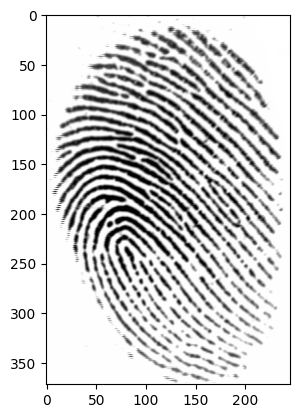

In [6]:
%matplotlib inline
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

The image has been imported as an array of values that range from 0 (black) to 255 (white). In between, there are multiple shades of gray that may represent noisy pixels. 

Therefore, a  process called **binarisation** is applied to the image in order to get rid of this noise and to enhance the shape of the fingerprint. 

To do so, use the `cv2.threshold()` function:

* _, img_bin = cv2.threshold(img, 127, 255, 0)

The argumants of the function indicate that all pixels with a value higher than 127 will become 255, and that pixels with a value smaller than 127 will become 0.

In [7]:
## Use this cell to write the code that will binarise the fingerprint image
ret, img_bin = cv2.threshold(img, 127, 255, 0)

Now you can see that the array only includes values 0 and 255.

In [9]:
img_bin

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Moreover, we can take a look at "img_bin" to see how the binarisation afects the image

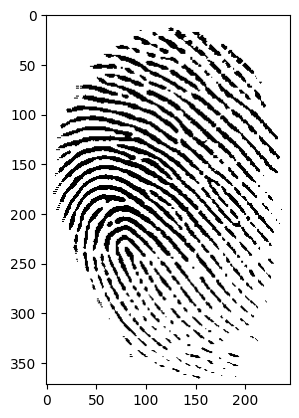

In [10]:
plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BGR2RGB))

## Skeletonisation

Now that the image has been binarised, we can apply a filter so that the ridges are thinned and it becomes easier to find the features. To do so, import the **skeletonize** module contained in `scikit-image` morphoology package (`skimage.morphology`):

* `from skimage.morphology import skeletonize`

Then we convert the 255 into 1 (since the skeletonisation method works only if the matrix contains ones and zeroes):

* `img_bin[img_bin == 255] = 1`

And finally, we apply the skeletonisation filter and create a new image called `img_skeleton`:

* `img_skeleton = np.asarray(skeletonize(img_bin), dtype=np.uint8)`

In [11]:
## Use this cell to write the code that will skeletonise the binarised fingerprint image
from skimage.morphology import skeletonize
img_bin[img_bin == 255] = 1
img_skeleton = np.asarray(skeletonize(img_bin), dtype=np.uint8)

Let's visualise the image (don't use the second parameter otherwise an all black image will appear):

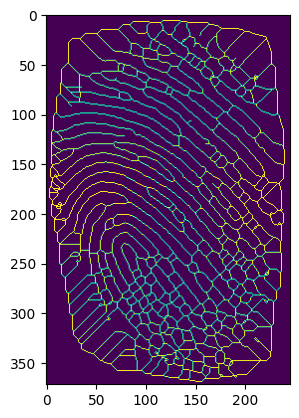

In [12]:
plt.imshow(img_skeleton)

## Findig the features

To find the feature points that describe the fingerprint, we will use two popular methods in image recognition: 

1. The first one is called Harris corners (which will transform the skeletonised image into a "Harris corner image" with indexes describing how likely a pixel is to be a corner).

2. The second is Scale Invariant Feature Transform (SIFT) which will extract a vector of descriptor for each of the candidate corners.

### Harris corners

To generate the Harris corners image, use the following commands:

* `harris_corners = cv2.cornerHarris(img_skeleton, 3, 3, 0.04)`
* `harris_corners_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)`

In [13]:
harris_corners = cv2.cornerHarris(img_skeleton, 3, 3, 0.04) 
harris_corners_norm = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

You will get a new matrix with different values than the previous ones; most of them showing $43.802277$ because we are only able to see the corners of the image

In [14]:
harris_corners_norm

array([[43.802277, 43.802277, 43.802277, ..., 43.802277, 43.802277,
        43.802277],
       [43.802277, 43.802277, 43.802277, ..., 43.802277, 43.802277,
        43.802277],
       [43.802277, 43.802277, 43.802277, ..., 43.802277, 43.802277,
        43.802277],
       ...,
       [43.802277, 43.802277, 43.802277, ..., 43.802277, 43.802277,
        43.802277],
       [43.802277, 43.802277, 43.802277, ..., 43.802277, 43.802277,
        43.802277],
       [43.802277, 43.802277, 43.802277, ..., 43.802277, 43.802277,
        43.802277]], dtype=float32)

Notice that if we inspect the Harris corners image, you will see that corners are represented in lighter colours, having a larger value than pixels which are less likely to be corners.

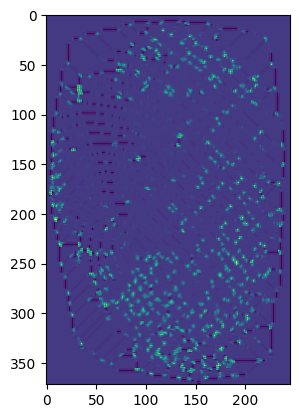

In [15]:
plt.imshow(harris_corners_norm)

### SIFT descriptors

To find the *descriptors (features)* for each corner, first we need to establish a **threshold value**. This means that if a pixel in the Harris corners image has a value larger than the threshold, then it is considered a true corner. We will set this threshold empirically as $125$. 

Then, we will scan the image for all rows and columns to find and extract the keypoints. Finally, we will extract the SIFT descriptors of each keypoint by using the `orb.create()` and the `orb.compute()` functions:

In [16]:
threshold_harris = 125
keys_101_1 = []
for x in range(0, harris_corners_norm.shape[0]):
    for y in range(0, harris_corners_norm.shape[1]):
        if harris_corners_norm[x][y] > threshold_harris:
            keys_101_1.append(cv2.KeyPoint(y, x, 1))
orb = cv2.ORB_create()
_, desc_101_1 = orb.compute(img, keys_101_1)

You can print the variable `desc` to inspect the features

In [17]:
desc_101_1

array([[ 75, 211,  81, ..., 178, 170, 189],
       [ 75, 209,  80, ..., 182, 170, 157],
       [  9, 122, 179, ...,  95,  19, 203],
       ...,
       [ 93,  29,  23, ...,  99,  35, 202],
       [ 20, 159,  23, ..., 101,  35,  98],
       [148, 171, 183, ..., 101,  39,  98]], dtype=uint8)

`desc_101_1` should be a numpy array with $1'215$ rows (each representing one true harris corner point) and $32$ columns (each representing a feature). If you are interested to know more about what each of these $32$ features represents, you can read the wikipedia entry for SIFT here:

https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

In [18]:
desc_101_1.shape

(1215, 32)

## Enrolling the Remaining Images

Now that the keypoints and descriptors for image `101_1.tif` are stored in variables `keys_101_1` and `desc_101_1` respectively, we will create a function called `enroll()` which you can simply call as many times as you need to enroll the remaining images.

In [19]:
## Use this cell to write a function that by being called three times, enrolls the images
def enroll(image_name):
    '''This function takes the name of the image as input and outputs the keypoints and descriptors.'''
    # Step 1: Load the fingerprint image (1 line of code).
    img = cv2.imread(image_name, 0)
    # Step 2: Binarise the loaded image (1 line of code).
    _, img_bin = cv2.threshold(img, 127, 255, 0)
    # Step 3: Skeletonise the binarised image (2 lines of code).
    img_bin[img_bin == 255] = 1
    img_skeleton = np.asarray(skeletonize(img_bin), dtype=np.uint8)
    # Step 4: Generate the normalised harris corners image from the skeletonised image (2 lines of code).
    harris_corners = cv2.cornerHarris(img_skeleton, 3, 3, 0.04)
    harris_corners_norm = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    # Step 5: Extract the SIFT features of the true harris corners with a threshold of 125 (8 lines of code).
    threshold_harris = 125
    keys = []
    for x in range(0, harris_corners_norm.shape[0]):
        for y in range(0, harris_corners_norm.shape[1]):
            if harris_corners_norm[x][y] > threshold_harris:
                keys.append(cv2.KeyPoint(y, x, 1))
    orb = cv2.ORB_create()
    _, desc = orb.compute(img, keys)
    return keys, desc

# Call the function three times
keys_101_2, desc_101_2 = enroll('/content/data_apug_2023-04/101_2.tif')
keys_102_1, desc_102_1 = enroll('/content/data_apug_2023-04/102_1.tif')
keys_102_2, desc_102_2 = enroll('/content/data_apug_2023-04/102_2.tif')

## Matching Fingerprints

Now that we have all keypoints and descriptors for each fingerprint, we will implement a brute force matching method that will attempt to find the best mapping between a pair of fingerprints.

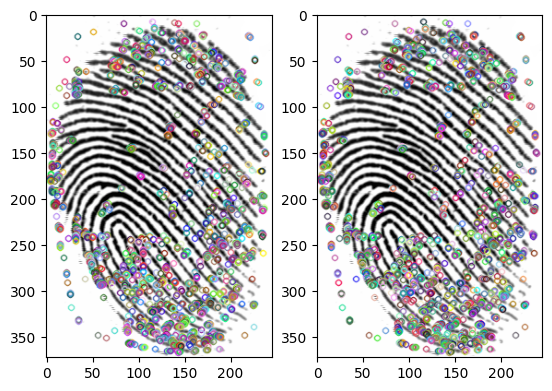

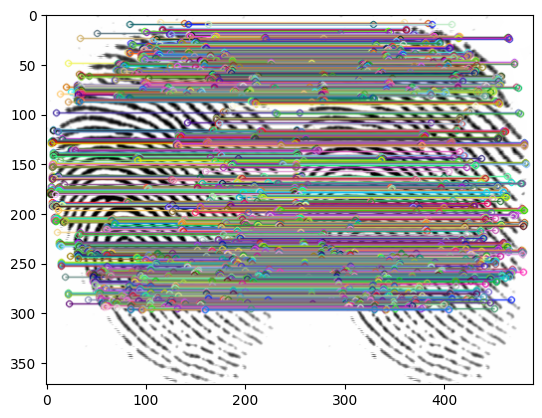

In [20]:
def enroll_and_match(image_nameA, image_nameB):
    keysA, descA = enroll(image_nameA)
    keysB, descB = enroll(image_nameB)
    imgA = cv2.imread(image_nameA, 1)
    imgB = cv2.imread(image_nameB, 1)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    match = sorted(bf.match(descA, descB), key= lambda match:match.distance)
    # Plot keypoints
    imgA_keys = cv2.drawKeypoints(imgA, keysA, outImage=None)
    imgB_keys = cv2.drawKeypoints(imgB, keysB, outImage=None)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(imgA_keys)
    axarr[1].imshow(imgB_keys)
    plt.show()
    # Plot matches
    
    ## with this code you only plot the matches that are potentially true
    plot_match = []
    for ma in match:
        if ma.distance < 73:
            plot_match.append(ma)
    
    img_match = cv2.drawMatches(imgA, keysA, imgB, keysB, plot_match, flags=2, outImg=None)
    plt.imshow(img_match)
    plt.show()
    return match

# Call the function
match = enroll_and_match('/content/data_apug_2023-04/101_1.tif',
                         '/content/data_apug_2023-04/101_1.tif')

## Evaluate the "goodness" of the match

As commented before, the key of biometrics is that you can never guarantee an exact match (unless you are comparing the same two images as above), but most of the times you are matching two images and declaring if they belong to the same subject or not based on a score/threshold. 

This score is calculated based on the distance between one matched feature and the other. Moreover, the score threshold is set empirically based on previous experiments

For this example, we will set the acceptance threshold equal to $55$. This means that if the matching obtains this score or lower, then the two fingerprints are of the same person, and if the value is higher, then the fingerprints don't match.

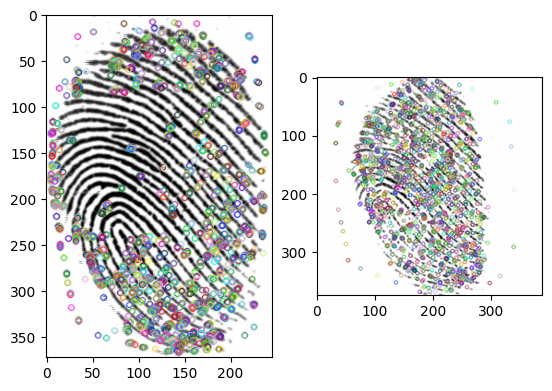

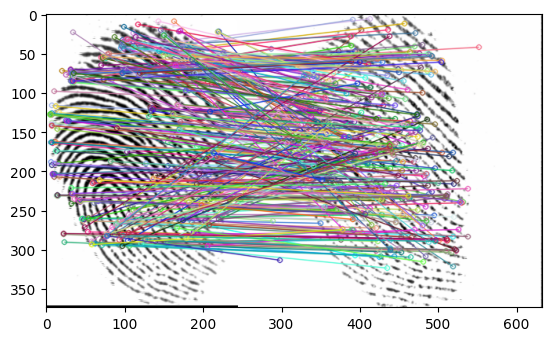

Score is 47.142458100558656
Fingerprints match.


In [21]:
def score(match):
    score = 0
    score_threshold = 55
    for ma in match:
        score += ma.distance
    score = score/len(match)
    print('Score is', score)
    if score < score_threshold:
        print("Fingerprints match.")
    else:
        print("Fingerprints do not match.")
    return

## With this code you can run enroll and match sequentially
match = enroll_and_match('/content/data_apug_2023-04/101_1.tif', 
                         '/content/data_apug_2023-04/101_2.tif')
score(match)

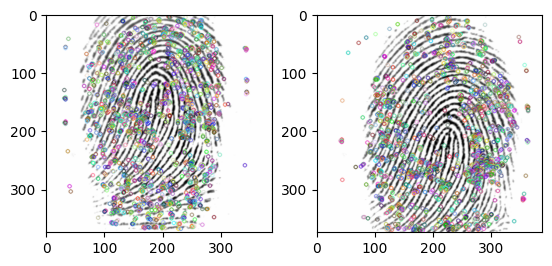

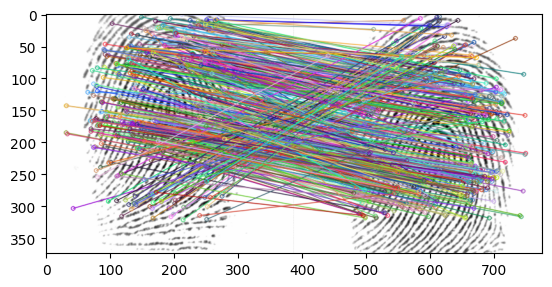

Score is 45.38419117647059
Fingerprints match.


In [22]:
## With this code you can run enroll and match sequentially
match = enroll_and_match('/content/data_apug_2023-04/102_1.tif', 
                         '/content/data_apug_2023-04/102_2.tif')
score(match)

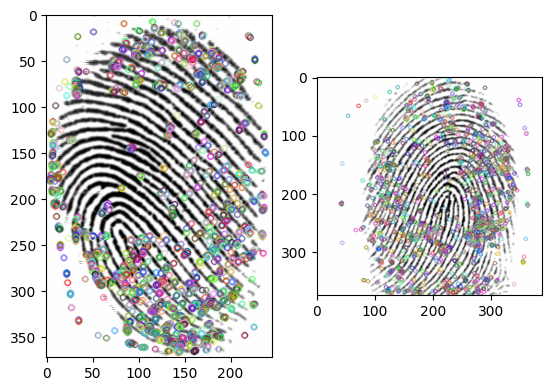

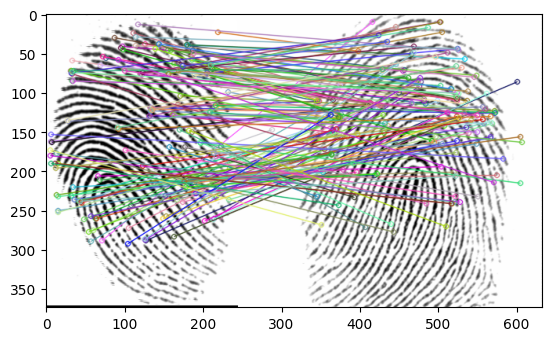

Score is 56.85326086956522
Fingerprints do not match.


In [23]:
## With this code you can run enroll and match sequentially
match = enroll_and_match('/content/data_apug_2023-04/101_1.tif', 
                         '/content/data_apug_2023-04/102_2.tif')
score(match)

This rationale applies also for palmprints and iris (eyes)

# Challenge time!

## For beginners
* Make sure the system works in your machine/colab account!
* Play with the parameters and the data to see how things change
* Can you load the data from Github rather than my dropbox?

## For intermediates
* Adapt the code so that it works with palmprints
  * You can get some images from here: https://www.dropbox.com/s/1ckcravisjwu31k/palms.zip?raw=1 or our GitHub!
* Change the Orb feature extractor to [SURF](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html) and see if it's any simpler/better

## For Experts
* As you have seen, we need to manually set the threshold to determine if there's a match!
  * Could this be done differently?
* Can you apply **STRUCTURAL** matching in the fingerprints or palms? The salient points detected are connected between them, and if we are able to understand these connections, then our matching algorithm would be more effective! Try to use [Delaunay triangulation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html) to generate a **graph** from the points. Afterwards, you can use [NetworkX Matching](https://networkx.org/documentation/stable/reference/algorithms/matching.html) or [GMatch4py](https://github.com/Jacobe2169/GMatch4py) to match the graphs.